In [1]:
pip install h2o_pysparkling_3.2

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pyspark
from pysparkling import *
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

In [2]:
spark = pyspark.sql.SparkSession.builder.appName("tbd") \
.master("local[*]") \
.config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5") \
.config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
.getOrCreate()

hc = H2OContext.getOrCreate()

Connecting to H2O server at http://d87d21ddf032:54324 ... successful.


H2O_cluster_uptime:,13 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,sparkling-water-jovyan_local-1672238815960
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.38.0.3-1-3.2
 * H2O name: sparkling-water-jovyan_local-1672238815960
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.17.0.2,54325)
  ------------------------

  Open H2O Flow in browser: http://d87d21ddf032:54324 (CMD + click in Mac OSX)

    


# zbilansujmy zbiór danych
Zacznujmy od zauważenia, że zbiór danych jest niezbilansowany. Próbowałem uczenia na niezbilansowanym zbiorze i nie przynosiło to dobrych efektów model praktycznie zawsze przewidywał jedną klasę.

<AxesSubplot:>

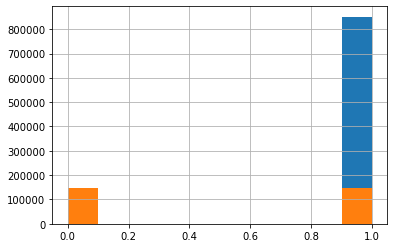

In [3]:
df = pd.read_csv("file:////home/jovyan/work/phase2Data/ds2-1e6.csv")
df['label'].astype(int).hist()
falseLabels = len(df[df['label'] == False])

newdf = df[df['label'] == False]
newdf = pd.concat([newdf, df[df['label'] == True].sample(falseLabels)])
newdf['label'].astype(int).hist()
# newdf.to_csv("ds2-1e6Balanced.csv")

In [4]:
user_name = 'jovyan'
csv_path = 'file:////home/jovyan/work/phase2Data/ds2-1e6Balanced.csv'
table_name = "accidents"                               # nazwa tabeli ktora bedziemy chcieli stworzyc

spark.sql(f'DROP TABLE IF EXISTS {table_name}')       # usun te tabele jesli istniala wczesniej 

# stworz tabele korzystajac z danych we wskazanej lokalizacji
spark.sql(f'CREATE TABLE IF NOT EXISTS {table_name} \
          USING csv \
          OPTIONS (HEADER true, INFERSCHEMA true, NULLVALUE "NA") \
          LOCATION "{csv_path}"')

DataFrame[]

In [5]:
spark.sql(f"select count(*) from {table_name}").show()

+--------+
|count(1)|
+--------+
|  297362|
+--------+



In [6]:
spark.sql(f"describe {table_name}").show(100, truncate=False) # niepoprawne typy danych... "NA" 

+-------------------------------------------+---------+-------+
|col_name                                   |data_type|comment|
+-------------------------------------------+---------+-------+
|_c0                                        |int      |null   |
|V1                                         |int      |null   |
|Accident_Index                             |string   |null   |
|Location_Easting_OSGR                      |double   |null   |
|Location_Northing_OSGR                     |double   |null   |
|Longitude                                  |double   |null   |
|Latitude                                   |double   |null   |
|Police_Force                               |int      |null   |
|Accident_Severity                          |int      |null   |
|Number_of_Vehicles                         |int      |null   |
|Number_of_Casualties                       |int      |null   |
|Date                                       |string   |null   |
|Day_of_Week                            

In [7]:
# za duża kardynalność
spark.sql(f"select count(distinct(Accident_Index)) from {table_name}").show()

+------------------------------+
|count(DISTINCT Accident_Index)|
+------------------------------+
|                        183892|
+------------------------------+



In [8]:
# dobra kardynalność
spark.sql(f"select count(distinct(Junction_Control)) from {table_name}").show()

+--------------------------------+
|count(DISTINCT Junction_Control)|
+--------------------------------+
|                               5|
+--------------------------------+



In [9]:
# dobra kardynalność
spark.sql(f"select count(distinct(Did_Police_Officer_Attend_Scene_of_Accident)) from {table_name}").show()

+-----------------------------------------------------------+
|count(DISTINCT Did_Police_Officer_Attend_Scene_of_Accident)|
+-----------------------------------------------------------+
|                                                          2|
+-----------------------------------------------------------+



# Pipeline

In [10]:
df = spark.sql(f"""
select 
    Number_of_Casualties,
    int(label),
    Police_Force,
    Number_of_Vehicles,
    Number_of_Casualties,
    Speed_limit,
    Urban_or_Rural_Area,
    Junction_Control,
    Light_Conditions,
    Weather_Conditions,
    Road_Surface_Conditions,
    Special_Conditions_at_Site,
    Carriageway_Hazards,
    Urban_or_Rural_Area,
    Did_Police_Officer_Attend_Scene_of_Accident
from {table_name}
""")


# Proper pipeline
# Number_of_CasualtiesScaler = StandardScaler(inputCol="Number_of_Casualtiesf", outputCol="Number_of_Casualties_Scaled")
string_indexer = StringIndexer(inputCols=["Junction_Control","Light_Conditions","Weather_Conditions","Road_Surface_Conditions","Special_Conditions_at_Site","Carriageway_Hazards","Did_Police_Officer_Attend_Scene_of_Accident"],
                               outputCols=["Junction_Control_SI","Light_Conditions_SI","Weather_Conditions_SI","Road_Surface_Conditions_SI","Special_Conditions_at_Site_SI","Carriageway_Hazards_SI","Did_Police_Officer_Attend_Scene_of_Accident_SI"])

onehot_encoder = OneHotEncoder(inputCols=["Speed_limit", "Urban_or_Rural_Area","Did_Police_Officer_Attend_Scene_of_Accident_SI"],
                               outputCols=["Speed_limit_OH", "Urban_or_Rural_Area_OH","Did_Police_Officer_Attend_Scene_of_Accident_OH"])

numerical_features = ['Number_of_Casualties', 'Police_Force', 'Number_of_Vehicles', 'Number_of_Casualties']
one_hot_features = ["Speed_limit_OH", "Urban_or_Rural_Area_OH","Did_Police_Officer_Attend_Scene_of_Accident_OH"]
string_indexer_features = ["Junction_Control_SI","Light_Conditions_SI","Weather_Conditions_SI","Road_Surface_Conditions_SI","Special_Conditions_at_Site_SI","Carriageway_Hazards_SI"]
vector_assembler = VectorAssembler(inputCols=numerical_features+one_hot_features+string_indexer_features, outputCol='features')

#Create pipeline and pass it to stages
pipeline = Pipeline(stages=[
    string_indexer,
    onehot_encoder,
    vector_assembler
])

#fit and transform
df_transformed = pipeline.fit(df).transform(df)
train, test = df_transformed.randomSplit([0.7, 0.3], seed=42)
print(f"train: {train.count()} test: {test.count()}")

train: 208029 test: 89333


# Logistic Regression

Spark

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


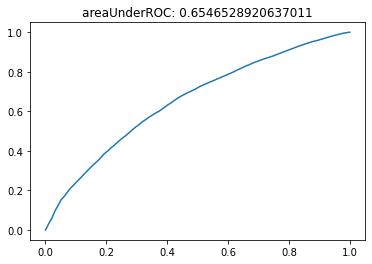

In [11]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression()

# Fit the model
lrModel = lr.fit(train)

roc = lrModel.summary.roc.toPandas()
plt.plot(roc['FPR'], roc['TPR'])
plt.title("areaUnderROC: " + str(lrModel.summary.areaUnderROC))
plt.show()

accuracy: 0.82


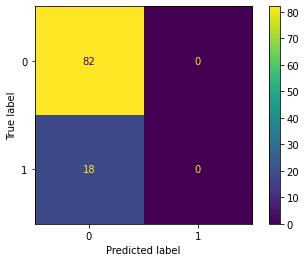

In [14]:
pddf = test.toPandas()

preds = []
for i in range(100):
    preds.append(lrModel.predict(pddf['features'][i]))
    
print(f"accuracy: {accuracy_score(preds, pddf['label'].values[:100])}")
cm = confusion_matrix(preds, pddf['label'].values[:100])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

H2O

In [15]:
trainH2O = hc.asH2OFrame(train)
testH2O = hc.asH2OFrame(test)

isFeature = []
for col in trainH2O.columns:
    isFeature.append("eatures" in col)

features_indexes = [i for i, x in enumerate(isFeature) if x]

glm_logistic = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic.train(x=features_indexes, y="label", training_frame=trainH2O, validation_frame=testH2O, model_id="glm_logistic")

glm Model Build progress: |

Dropping bad and constant columns: [features.26, features.25, features.69, features.28, features.27, features.22, features.66, features.21, features.65, features.68, features.23, features.67, features.29, features.62, features.61, features.20, features.63, features.60, features.37, features.36, features.39, features.38, features.33, features.32, features.35, features.73, features.72, features.31, features.30, features.74, features.71, features.70, features.5, features.48, features.6, features.47, features.7, features.8, features.49, features.43, features.46, features.4, features.45, features.9, features.40, features.42, features.41, features.15, features.59, features.58, features.17, features.16, features.11, features.55, features.10, features.13, features.57, features.12, features.56, features.18, features.51, features.50, features.53, features.52]
We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression mod

██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: glm_logistic


GLM Model: summary
    family    link    regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 1.811E-4 )  20                            19                             4                       frame_rdd_174-1104526177

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23231820316231067
RMSE: 0.48199398664538406
LogLoss: 0.65716937156802
AUC: 0.6546366811164667
AUCPR: 0.6388031386002515
Gini: 0.30927336223293334
Null degrees of freedom: 208028
Residual degrees of freedom: 208009
Null deviance: 288389.4285678186
Residual deviance: 273420.5743958473
AIC: 273460.5743958473

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35047229355093945
       0      1       Error    Rate
-----  -----  ------  -------  ------------------
0      15471  88551   0.8513   (88551.0/104022.0)
1      6217   97790   0.0598   (6217.0/104007.0)
Total  21688  186341  0.4556   (94768.0/208029.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.350472     0.673605  299
max f2                       0.175118     0.833522  377
max f0point5                 0.471534     0.616668  211
max accuracy                 0.471534     0.616078  211
max precision                0.748109     0.755755  51
max recall                   0.0025062    1         399
max specificity              0.99296      0.999942  0
max absolute_mcc             0.471534     0.233165  211
max min_per_class_accuracy   0.487205     0.611659  199
max mean_per_class_accuracy  0.471534     0.616081  211
max tns                      0.99296      104016    0
max fns                      0.99296      104004    0
max fps                      0.0025062    104022    399
max tps                      0.0025062    104007    399
max tnr                      0.99296      0.999942  0
max fnr                      0.99296      0.999971  0
max fpr                      0.0025062    1         399
max tpr                      0.0025062    1         399

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 50.00 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100178                   0.799997           1.455     1.455              0.727447         0.833489  0.727447                    0.833489            0.0145759       0.0145759                  45.4999   45.4999            0.00911556
2        0.020002                    0.776379           1.54176   1.49831            0.770823         0.789215  0.749099                    0.811389            0.0153932       0.0299691                  54.1758   49.8306            0.0199328
3        0.0300439                   0.766797           1.43428   1.47691            0.71709          0.76906   0.7384                      0.797241            0.0144029       0.044372                   43.4282   47.6906            0.0286542
4        0.040004                    0.763693           1.48756   1.47956            0.743726         0.765075  0.739726                    0.789233            0.0148163       0.05918

In [16]:
trainH2O = hc.asH2OFrame(spark.sql(f"select * from {table_name}")).drop("Accident_Severity")

glm_logistic = H2OGeneralizedLinearEstimator()
glm_logistic.train(x=[i for i in range(32)], y=32, training_frame=trainH2O, model_id="glm_logistic")

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: glm_logistic


GLM Model: summary
    family    link      regularization                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.06141 )  222096                        10                             2                       py_1_sid_addd

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 8.922995198022475
RMSE: 2.9871382957644386
MAE: 2.628515698599171
RMSLE: 0.0014858896179567543
Mean Residual Deviance: 8.922995198022475
R^2: 0.016996511942194092
Null degrees of freedom: 297361
Residual degrees of freedom: 297351
Null deviance: 2699237.3174011772
Residual deviance: 2653359.698074359
AIC: 1494716.6922917706

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse       training_deviance    training_mae       training_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  ------------------  -------------------  -----------------  --------------------
    2022-12-28 14:50:42  0.000 sec   0             2699237.3174011772         9.077277249282616
    2022-12-28 14:50:42  0.558 sec   2                                                           2.9871382957644386  8.922995198022475    2.628515698599171  0.016996511942194092

Variable Importances: 
variable                                                                       relative_importance    scaled_importance      percentage
-----------------------------------------------------------------------------  ---------------------  ---------------------  ---------------------
V1                                                                             0.31825628876686096    1.0                    0.4751216260974827
Speed_limit                                                                    0.10329869389533997    0.3245770705602979     0.15421358555856612
Local_Authority_(District)                                                     0.09225358814001083    0.2898720037786632     0.13772445779545409
Pedestrian_Crossing-Physical_Facilities.No physical crossing within 50 meters  0.04795921966433525    0.15069370616417838    0.07159783871538068
Number_of_Casualties                                                           0.037920258939266205   0.11915006954362098    0.05661077479119335
Police_Force                                                                   0.024261722341179848   0.07623328492639089    0.03622008229697956
2nd_Road_Class                                                                 0.018457120284438133   0.05799451868163686    0.027554450020760145
1st_Road_Class                                                                 0.015014765784144402   0.04717822181086102    0.022415393463164013
Location_Easting_OSGR                                                          0.01178897637873888    0.037042398830255036   0.017599644766782264
Longitude                                                                      0.0006310890312306583  0.0019829585573184487  0.0009421464942370598
---                                                                            ---                    ---                    ---
Did_Police_Officer_Attend_Scene_of_Accident.No                                 0.0                    0.0                    0.0
Did_Police_Officer_Attend_Scene_of_Accident.Yes                                0.0                    0.0                    0.0
_c0                                                                            0.0                    0.0                    0.0
Location_Northing_OSGR                       

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

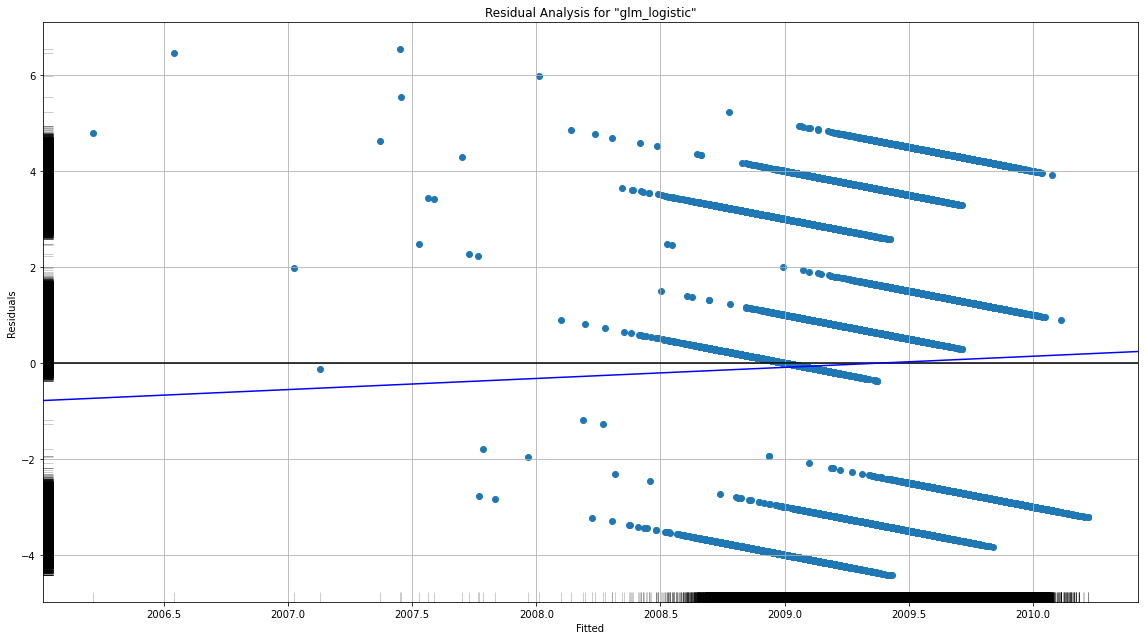

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

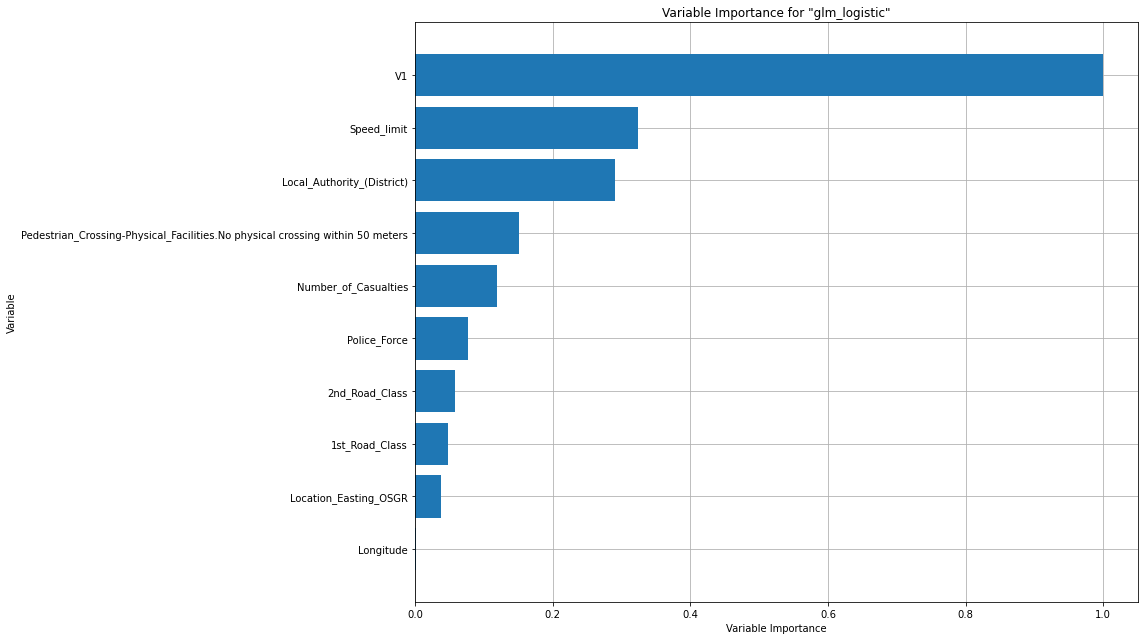

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

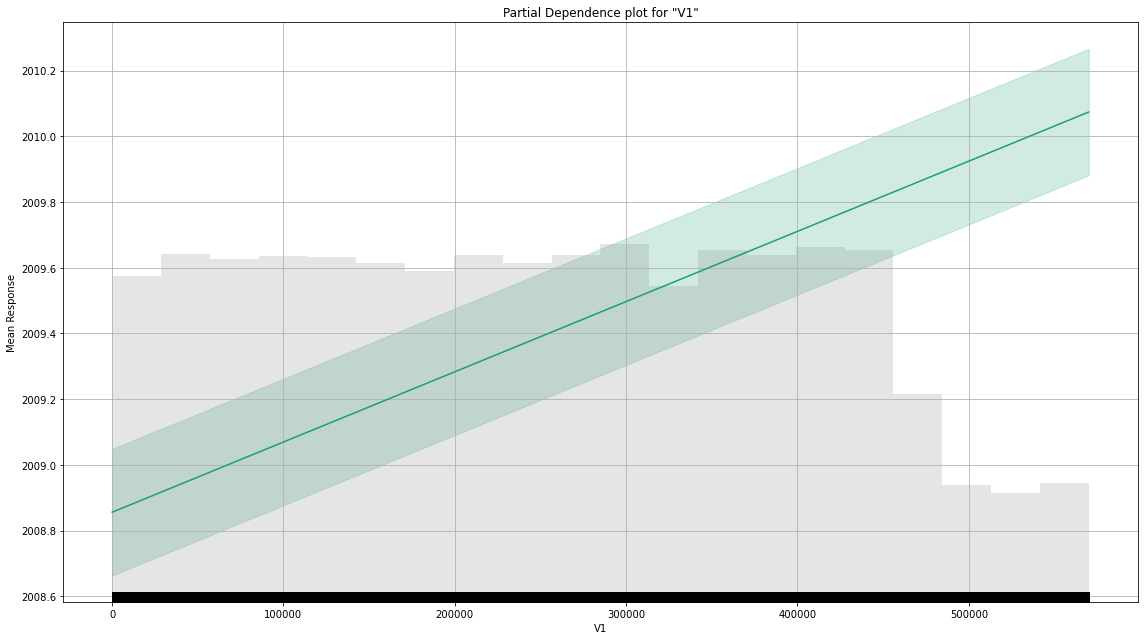

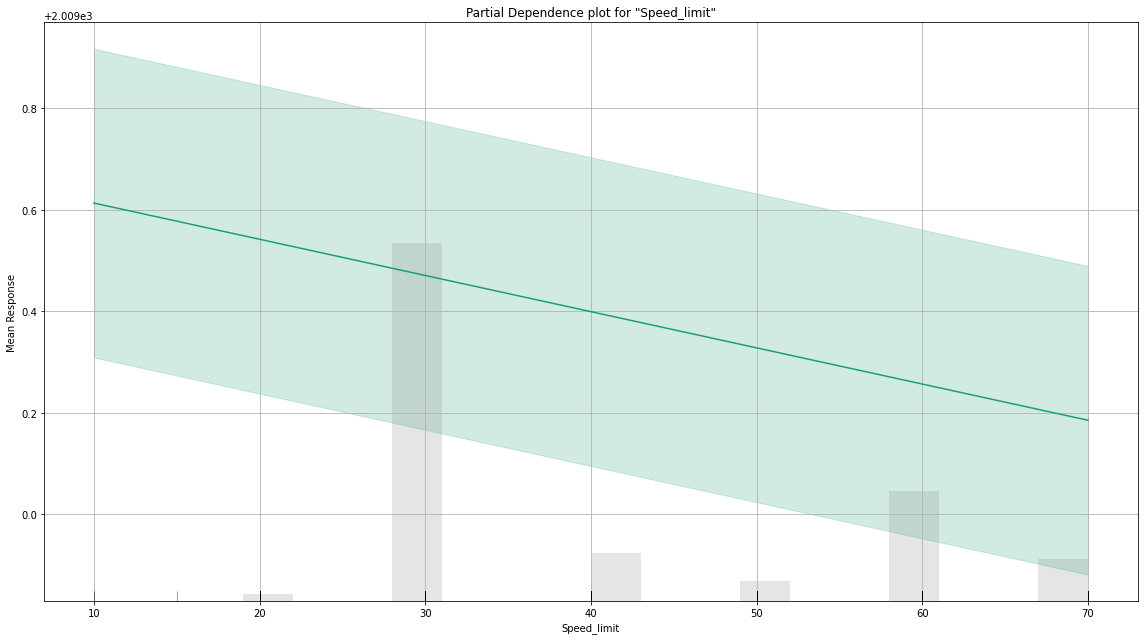

H2OJobCancelled: Job<$0301ac11000236d4ffffffff$_ab0b28378e39c7f240aad92ec1b24d69> was cancelled by the user.

<Figure size 1152x648 with 0 Axes>

In [17]:
# glm_logistic.explain(trainH2O)

# Sklearn

In [34]:
data = df_transformed.toPandas()
y = data['label']

numerical_features = ['Number_of_Casualties', 'Police_Force', 'Number_of_Vehicles', 'Number_of_Casualties']

X, y = data[numerical_features], data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
preds = clf.predict(X_test)

print(f"accuracy: {accuracy_score(preds, y_test)}")
print(f"roc: {roc_auc_score(preds, y_test)}")
cm = confusion_matrix(preds, y_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Porównanie czasu wykonania

In [30]:
from pyspark.ml.classification import LogisticRegression

executionTime = pd.DataFrame(columns=['framework','cores','time'])

for n in range(1,12):
    spark = pyspark.sql.SparkSession.builder.appName("tbd") \
    .master("local[*]") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5") \
    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
    .config("spark.executor.cores",n) \
    .getOrCreate()

    st = time.time()
    lr = LogisticRegression()
    lrModel = lr.fit(train)
    et = time.time()
    executionTime = pd.concat([executionTime, pd.DataFrame({'framework':['spark'],'cores':[n],'time':[et-st]})])

In [31]:
for n in range(1,12):
    spark = pyspark.sql.SparkSession.builder.appName("tbd") \
    .master("local[*]") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.5") \
    .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
    .config("spark.executor.cores",n) \
    .getOrCreate()
    hc = H2OContext.getOrCreate()

    trainH2O = hc.asH2OFrame(spark.sql(f"select * from {table_name}")).drop("Accident_Severity")
    st = time.time()
    glm_logistic = H2OGeneralizedLinearEstimator()
    glm_logistic.train(x=[i for i in range(32)], y=32, training_frame=trainH2O, model_id="glm_logistic")
    et = time.time()
    executionTime = pd.concat([executionTime, pd.DataFrame({'framework':['H2O'],'cores':[n],'time':[et-st]})])

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


KeyboardInterrupt: 

In [35]:
from sklearn.linear_model import LogisticRegression
st = time.time()
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
et = time.time()
executionTime = pd.concat([executionTime, pd.DataFrame({'framework':['sklearn'],'cores':[n],'time':[et-st]})])

In [40]:
executionTime

,framework,cores,time
0,spark,1,5.765385
0,spark,2,5.426627
0,spark,3,4.794327
0,spark,4,4.970194
0,spark,5,5.598119
0,spark,6,5.564003
0,spark,7,5.635693
0,spark,8,5.480626
0,spark,9,5.517029
0,spark,10,6.103308


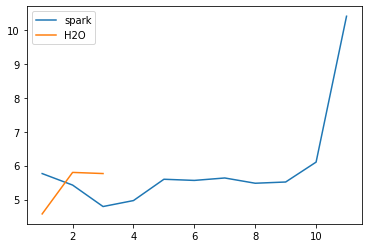

In [48]:
x = executionTime[executionTime['framework']=='spark']['cores']
y = executionTime[executionTime['framework']=='spark']['time']
plt.plot(x,y)
x = executionTime[executionTime['framework']=='H2O']['cores']
y = executionTime[executionTime['framework']=='H2O']['time']
plt.plot(x,y)
plt.legend(['spark','H2O'])
plt.show()

# Wnioski

Praca ze sparkiem jest miła i przyjemna, H2O fajne, ponieważ robi wiele rzeczy za nas podajemy mu dane i transformacja danych zachodzi sama oraz otrzymujemy piękne wykresy wyjaśniające model i dane. H2O mocno zachacza a autoML. Sklearn działa, jak widać wykorzystując tylko kilka cech numerycznych otrzymujemy jako tako działający model accyracy jest równe 85% ale z racji nie zbilansowanego zbioru model praktycznie zawsze przewiduje 1. Czasy wykonania pokazują, że implementacja w sklearn jest najszybsza.

# GBT